<a href="https://colab.research.google.com/github/haberkornm/Convolutional-Neural-Network-Of-Corn-Leaf-Disease-Images/blob/main/CNN_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
#Mounting google drive so images can be loaded
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This does not need to be run again
#Only needs to be run when new images need to be unzipped and loaded.
#Unzips file in google drive and makes them accessable in colab folder
#import zipfile  # unziping 

#Unzip images
#path = '/content/drive/MyDrive/stacked_imgs.zip'
#with zipfile.ZipFile(path, 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/CNN')

In [ ]:
#Setting image parameters for Keras
batch_size = 32
img_height = 180
img_width = 1260

In [ ]:
path = "/content/drive/MyDrive/CNN/stacked"

In [ ]:
#creating training set of raw images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [ ]:
#creating validation set of raw images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [ ]:
#viewing class names for training and validation data, viewing both to ensure they are the same
class_names = train_ds.class_names
print('Training class names:', class_names)
print('Validation class names:', val_ds.class_names)

Training class names: ['Blight', 'Common_Rust', 'Gray_Spot', 'Healthy']
Validation class names: ['Blight', 'Common_Rust', 'Gray_Spot', 'Healthy']


#VGG16 without data augmentation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#load VGG16 model for transfer learning
#https://www.tensorflow.org/guide/keras/transfer_learning
base_model = VGG16(include_top=False, input_shape=(180, 1260, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [ ]:
#Make VGG16 base model not trainable
base_model.trainable = False

In [ ]:
#Add input and output layers to VGG16
inputs = keras.Input(shape=(180, 1260, 3))

x = base_model(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)

In [ ]:
#Compile model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 1260, 3)]    0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 39, 512)        14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


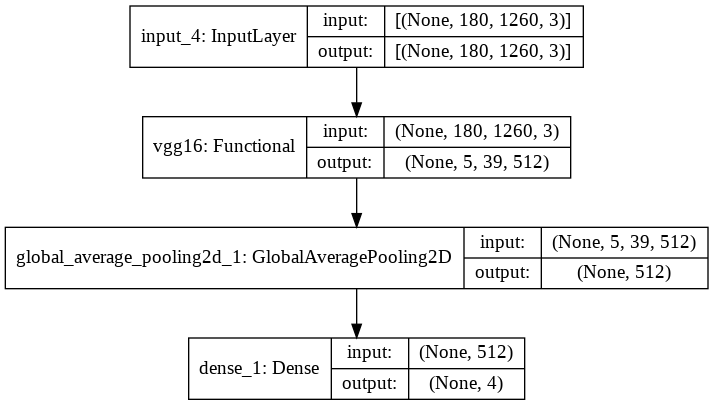

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
epochs=60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, callbacks=[monitor_val_loss])

Epoch 1/60
105/105 [==============================] - 684s 6s/step - loss: 1.0461 - accuracy: 0.6655 - val_loss: 0.5366 - val_accuracy: 0.8041
Epoch 2/60
105/105 [==============================] - 34s 326ms/step - loss: 0.3854 - accuracy: 0.8690 - val_loss: 0.3538 - val_accuracy: 0.8769
Epoch 3/60
105/105 [==============================] - 34s 326ms/step - loss: 0.2693 - accuracy: 0.9105 - val_loss: 0.2903 - val_accuracy: 0.8961
Epoch 4/60
105/105 [==============================] - 34s 326ms/step - loss: 0.2147 - accuracy: 0.9332 - val_loss: 0.2579 - val_accuracy: 0.9032
Epoch 5/60
105/105 [==============================] - 34s 325ms/step - loss: 0.1817 - accuracy: 0.9436 - val_loss: 0.2393 - val_accuracy: 0.9068
Epoch 6/60
105/105 [==============================] - 34s 325ms/step - loss: 0.1585 - accuracy: 0.9517 - val_loss: 0.2270 - val_accuracy: 0.9092
Epoch 7/60
105/105 [==============================] - 34s 325ms/step - loss: 0.1407 - accuracy: 0.9564 - val_loss: 0.2174 - val_accu

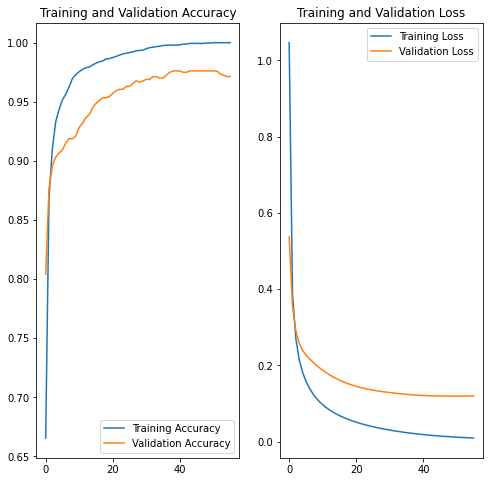

In [ ]:
#Graph accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

27/27 [==============================] - 7s 253ms/step - loss: 0.1192 - accuracy: 0.9761
initial loss: 0.119
initial accuracy: 0.976


In [ ]:
#Save model and architecture to a h5 file
model.save("my_model.h5")

# Data Augmentation

In [ ]:
#Image augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

In [ ]:
#Using original model with image augmentation
num_classes = 4

model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=50
history2 = model2.fit(
  train_ds,
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/50
105/105 [==============================] - 207s 2s/step - loss: 1.5882 - accuracy: 0.6944 - val_loss: 0.3492 - val_accuracy: 0.8734
Epoch 2/50
105/105 [==============================] - 21s 197ms/step - loss: 0.2382 - accuracy: 0.9155 - val_loss: 0.2012 - val_accuracy: 0.9247
Epoch 3/50
105/105 [==============================] - 21s 197ms/step - loss: 0.1528 - accuracy: 0.9540 - val_loss: 0.2225 - val_accuracy: 0.9164
Epoch 4/50
105/105 [==============================] - 21s 197ms/step - loss: 0.1203 - accuracy: 0.9588 - val_loss: 0.1879 - val_accuracy: 0.9271
Epoch 5/50
105/105 [==============================] - 21s 196ms/step - loss: 0.0714 - accuracy: 0.9770 - val_loss: 0.1500 - val_accuracy: 0.9594
Epoch 6/50
105/105 [==============================] - 21s 196ms/step - loss: 0.0562 - accuracy: 0.9824 - val_loss: 0.1347 - val_accuracy: 0.9594
Epoch 7/50
105/105 [==============================] - 21s 196ms/step - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.1671 - val_accu

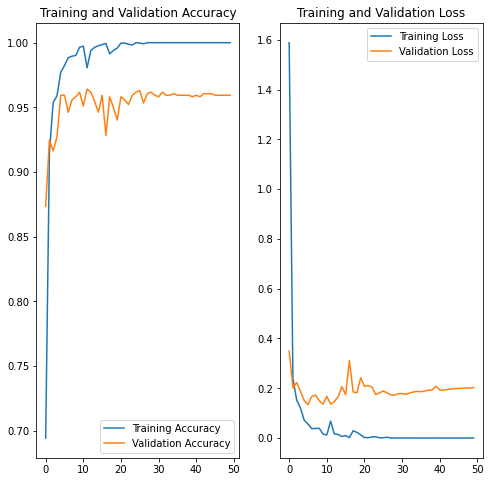

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss0, accuracy0 = model2.evaluate(val_ds)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

27/27 [==============================] - 3s 101ms/step - loss: 0.2028 - accuracy: 0.9594
initial loss: 0.203
initial accuracy: 0.959


In [ ]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 1260, 3)      0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 180, 1260, 3)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 178, 1258, 32)     896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 89, 629, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 87, 627, 32)       9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 43, 313, 32)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 430688)          



```
`# This is formatted as code`
```

# Model without Augmentation

In [ ]:
num_classes = 4

model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=25
history2 = model2.fit(
  train_ds,
  validation_data=val_ds, 
  epochs=epochs)

Epoch 1/25
105/105 [==============================] - 15s 131ms/step - loss: 1.1935 - accuracy: 0.6598 - val_loss: 0.3642 - val_accuracy: 0.8495
Epoch 2/25
105/105 [==============================] - 13s 122ms/step - loss: 0.1614 - accuracy: 0.9415 - val_loss: 0.2569 - val_accuracy: 0.9164
Epoch 3/25
105/105 [==============================] - 13s 122ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 0.1346 - val_accuracy: 0.9546
Epoch 4/25
105/105 [==============================] - 13s 122ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1505 - val_accuracy: 0.9534
Epoch 5/25
105/105 [==============================] - 13s 122ms/step - loss: 2.3951e-04 - accuracy: 1.0000 - val_loss: 0.1563 - val_accuracy: 0.9534
Epoch 6/25
105/105 [==============================] - 13s 122ms/step - loss: 1.3847e-04 - accuracy: 1.0000 - val_loss: 0.1624 - val_accuracy: 0.9510
Epoch 7/25
105/105 [==============================] - 13s 122ms/step - loss: 9.7095e-05 - accuracy: 1.0000 - val_loss: 0.1

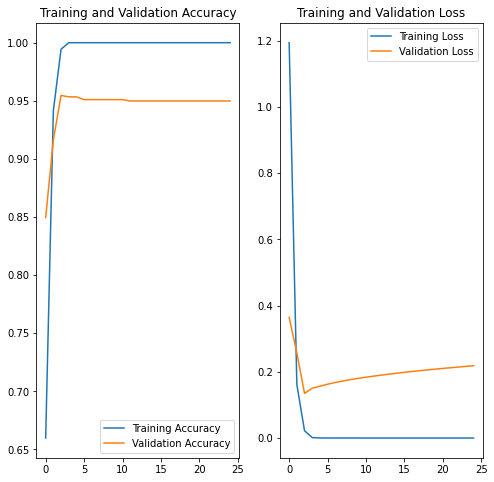

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss0, accuracy0 = model2.evaluate(val_ds)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

27/27 [==============================] - 1s 37ms/step - loss: 0.2183 - accuracy: 0.9498
initial loss: 0.218
initial accuracy: 0.950


# VGG16 with image augmentation

In [ ]:
#Image augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

In [ ]:
#Adding image augmentation and input and output layers to VGG16 base model
inputs = keras.Input(shape=(180, 1260, 3))
x = data_augmentation(inputs) 

x = base_model(x, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 1260, 3)]    0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 1260, 3)      0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 39, 512)        14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
105/105 [==============================] - 36s 334ms/step - loss: 1.2072 - accuracy: 0.6335 - val_loss: 0.5172 - val_accuracy: 0.8065
Epoch 2/25
105/105 [==============================] - 35s 332ms/step - loss: 0.4148 - accuracy: 0.8559 - val_loss: 0.3543 - val_accuracy: 0.8757
Epoch 3/25
105/105 [==============================] - 35s 332ms/step - loss: 0.3227 - accuracy: 0.8890 - val_loss: 0.3054 - val_accuracy: 0.8793
Epoch 4/25
105/105 [==============================] - 35s 332ms/step - loss: 0.2553 - accuracy: 0.9191 - val_loss: 0.2695 - val_accuracy: 0.9008
Epoch 5/25
105/105 [==============================] - 35s 332ms/step - loss: 0.2182 - accuracy: 0.9269 - val_loss: 0.2430 - val_accuracy: 0.9152
Epoch 6/25
105/105 [==============================] - 35s 332ms/step - loss: 0.1946 - accuracy: 0.9364 - val_loss: 0.2545 - val_accuracy: 0.8901
Epoch 7/25
105/105 [==============================] - 35s 332ms/step - loss: 0.1834 - accuracy: 0.9406 - val_loss: 0.2254 - val_ac

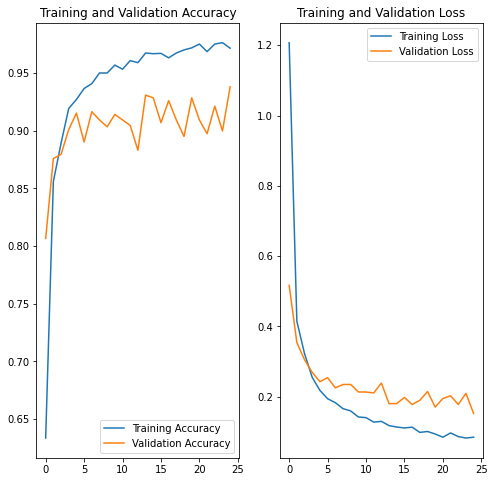

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

27/27 [==============================] - 7s 253ms/step - loss: 0.1524 - accuracy: 0.9379
initial loss: 0.152
initial accuracy: 0.938


#Model with RGB images

In [ ]:
#Path to original RGB images
data_path = '/content/drive/MyDrive/CNN/data'

In [ ]:
#creating training set of raw images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [ ]:
#creating validation set of raw images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [ ]:
#viewing class names for training and validation data, viewing both to ensure they are the same
class_names = train_ds.class_names
print('Training class names:', class_names)
print('Validation class names:', val_ds.class_names)

Training class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Validation class names: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Image augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

In [ ]:
#Using original model with image augmentation
num_classes = 4

model5 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history5 = model5.fit(
  train_ds,
  validation_data=val_ds, 
  epochs=epochs)

Epoch 1/10
105/105 [==============================] - 20s 173ms/step - loss: 0.7830 - accuracy: 0.7332 - val_loss: 0.4317 - val_accuracy: 0.8268
Epoch 2/10
105/105 [==============================] - 10s 91ms/step - loss: 0.3700 - accuracy: 0.8475 - val_loss: 0.3633 - val_accuracy: 0.8363
Epoch 3/10
105/105 [==============================] - 9s 90ms/step - loss: 0.3629 - accuracy: 0.8559 - val_loss: 0.4823 - val_accuracy: 0.7814
Epoch 4/10
105/105 [==============================] - 9s 90ms/step - loss: 0.2986 - accuracy: 0.8702 - val_loss: 0.3447 - val_accuracy: 0.8495
Epoch 5/10
105/105 [==============================] - 9s 90ms/step - loss: 0.2690 - accuracy: 0.8908 - val_loss: 0.4027 - val_accuracy: 0.8519
Epoch 6/10
105/105 [==============================] - 9s 90ms/step - loss: 0.2553 - accuracy: 0.8979 - val_loss: 0.3205 - val_accuracy: 0.8722
Epoch 7/10
105/105 [==============================] - 9s 90ms/step - loss: 0.2256 - accuracy: 0.9063 - val_loss: 0.3305 - val_accuracy: 0.8

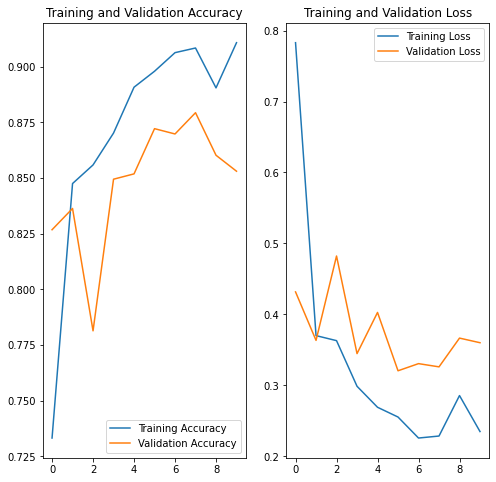

In [ ]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss0, accuracy0 = model5.evaluate(val_ds)
print("initial loss: {:.3f}".format(loss0))
print("initial accuracy: {:.3f}".format(accuracy0))

27/27 [==============================] - 1s 33ms/step - loss: 0.3600 - accuracy: 0.8530
initial loss: 0.360
initial accuracy: 0.853


In [ ]:
model5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 1260, 3)      0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 180, 1260, 3)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 178, 1258, 32)     896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 89, 629, 32)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 87, 627, 32)       9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 43, 313, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 311, 32)      

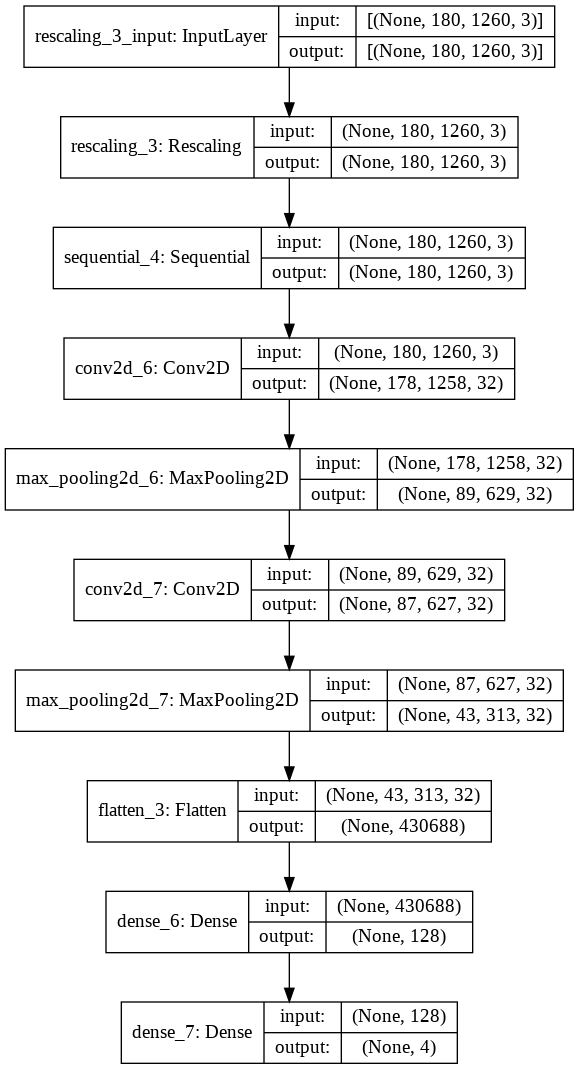

In [ ]:

from tensorflow.keras.utils import plot_model
plot_model(model5, show_shapes=True, show_layer_names=True)